<a href="https://colab.research.google.com/github/MadmanMarble/Planet_U-NET/blob/main/Planet_U-NET_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
pip install rasterio

In [3]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import rasterio
from sklearn.model_selection import train_test_split
import shutil
from tensorflow.keras.utils import Sequence, to_categorical
import numpy as np
import rasterio
import cv2
from keras.utils import to_categorical
import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from osgeo import gdal

In [60]:
# Ensure the lists are sorted so that images and labels correspond to each other
# load planet iamges
planet_images = sorted(glob.glob(f"/content/drive/MyDrive/DeepLearning_Project/unet_planet_data/planet_images/*.tif"))
# load planet labels
planet_labels = sorted(glob.glob(f"/content/drive/MyDrive/DeepLearning_Project/unet_planet_data/planet_labels/*.tif"))

# Split the file paths into training and testing sets (85% train, 15% test)
train_images_paths, val_images_paths, train_labels_paths, val_labels_paths = train_test_split(
    planet_images, planet_labels, test_size=0.15, random_state=42)

In [61]:
print("Total number of images:", len(planet_images))
print("Total number of labels:", len(planet_labels))
print("Number of training images:", len(train_images_paths))
print("Number of training labels:", len(train_labels_paths))
print("Number of validation images:", len(val_images_paths))
print("Number of validation labels:", len(val_labels_paths))

Total number of images: 2825
Total number of labels: 2825
Number of training images: 2401
Number of training labels: 2401
Number of validation images: 424
Number of validation labels: 424


In [ ]:
# Destination directory
destination = '/content/train_images'

# Ensure the destination directory exists
os.makedirs(destination, exist_ok=True)

# Loop through the list and copy each file
for file in train_images_paths:
    # Define the full destination path for the current file
    dest_file = os.path.join(destination, os.path.basename(file))
    # Copy the file
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')



# Destination directory
destination = '/content/train_labels'

# Ensure the destination directory exists
os.makedirs(destination, exist_ok=True)

# Loop through the list and copy each file
for file in train_labels_paths:
    # Define the full destination path for the current file
    dest_file = os.path.join(destination, os.path.basename(file))
    # Copy the file
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')

# Destination directory
destination = '/content/val_images'

# Ensure the destination directory exists
os.makedirs(destination, exist_ok=True)

# Loop through the list and copy each file
for file in val_images_paths:
    # Define the full destination path for the current file
    dest_file = os.path.join(destination, os.path.basename(file))
    # Copy the file
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')


# Destination directory
destination = '/content/val_labels'

# Ensure the destination directory exists
os.makedirs(destination, exist_ok=True)

# Loop through the list and copy each file
for file in val_labels_paths:
    # Define the full destination path for the current file
    dest_file = os.path.join(destination, os.path.basename(file))
    # Copy the file
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')

In [64]:
train_images_paths = sorted(glob.glob(f"/content/train_images/*.tif"))
train_labels_paths = sorted(glob.glob(f"/content/train_labels/*.tif"))


val_images_paths = sorted(glob.glob(f"/content/val_images*.tif"))
val_labels_paths = sorted(glob.glob(f"/content/val_labels/*.tif"))

In [65]:
# prompt: User
# how can I find the unique number of classes within a folder of data, where each file within the folder is a different .tif file, and they may have different classes within them. for example, train_labels_paths is where my data is, and there could be 6 different classes in one file and 9 different classes in the next file.

import numpy as np
# Get a list of all the unique classes in the training labels folder
classes = []
for label_path in val_labels_paths:
    # Open the label file
    with rasterio.open(label_path) as label:
        # Get the unique classes in the label file
        unique_classes = np.unique(label.read(1))
        # Add the unique classes to the list
        classes.extend(unique_classes)

# Remove any duplicate classes from the list
classes = list(set(classes))

# Print the number of unique classes
print("Number of unique classes:", len(classes))
print(classes)

Number of unique classes: 13
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]


In [38]:
num_classes = classes

In [66]:
src_ds = gdal.Open(train_images_paths[155])
if src_ds is not None:
    print ("band count: " + str(src_ds.RasterCount))

src_ds = gdal.Open(train_labels_paths[155])
if src_ds is not None:
    print ("band count: " + str(src_ds.RasterCount))

band count: 13
band count: 1


In [68]:
# Inspect the train images dataset
src_ds = gdal.Open(train_images_paths[155])
if src_ds is not None:
    print("Band count:", src_ds.RasterCount)

    # Read the first band's data
    band = src_ds.GetRasterBand(1)
    band_data = band.ReadAsArray()

    # Find unique values in the band data
    unique_classes = np.unique(band_data)
    print("Unique classes:", unique_classes)

In [69]:
# Inspect the train labels dataset
src_ds = gdal.Open(train_labels_paths[155])
if src_ds is not None:
    print("Band count:", src_ds.RasterCount)

    # Read the first band's data
    band = src_ds.GetRasterBand(1)
    band_data_labels = band.ReadAsArray()

    # Find unique values in the band data
    unique_classes = np.unique(band_data_labels)
    print("Unique classes:", unique_classes)

Band count: 1
Unique classes: [ 2.  3.  6. 10. 11.]


(384, 384)


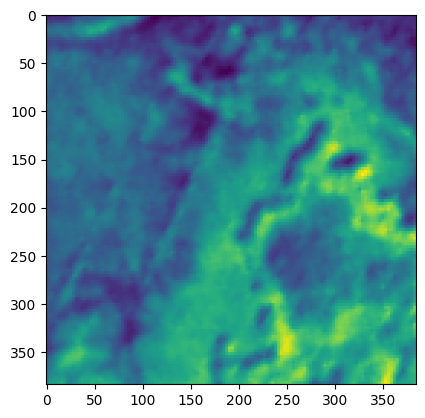

In [72]:
# What does one image and corresponding label look like?
dataset = gdal.Open(train_images_paths[155])
band = dataset.GetRasterBand(8) # band 4 to show NIR
array = band.ReadAsArray()
print(array.shape)
plt.imshow(array)

(384, 384)


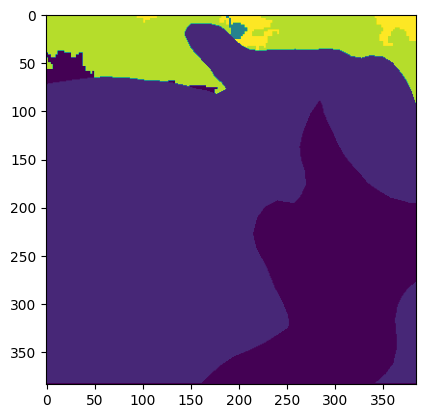

In [71]:
# What does one image and corresponding label look like?
dataset = gdal.Open(train_labels_paths[155])
band = dataset.GetRasterBand(1) # band 1 bc there is only 1 band
array = band.ReadAsArray()
print(array.shape)
plt.imshow(array)

In [73]:
class DataGenerator(Sequence):
    def __init__(self, image_files, label_files, img_height, img_width, batch_size, num_classes):
        self.image_files = image_files
        self.label_files = label_files
        self.img_height = img_height
        self.img_width = img_width
        self.batch_size = batch_size
        self.num_classes = num_classes

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

    def __getitem__(self, index):
        image_batch_files = self.image_files[index * self.batch_size : (index + 1) * self.batch_size]
        label_batch_files = self.label_files[index * self.batch_size : (index + 1) * self.batch_size]

        batch_images, batch_labels = self.load_images_and_labels(image_batch_files, label_batch_files)
        return batch_images, batch_labels

    def load_and_reshape_image(self, image_path):
        with rasterio.open(image_path) as src:
            image = src.read().transpose((1, 2, 0))
            if image.shape[:2] != (self.img_height, self.img_width):
                image = cv2.resize(image, (self.img_width, self.img_height), interpolation=cv2.INTER_NEAREST)
        return image

    # def z_score_normalization(self, image):
    #     # epsilon = 1e-7
    #     # mean = np.mean(image, axis=(0, 1), keepdims=True)
    #     # std = np.std(image, axis=(0, 1), keepdims=True)
    #     # std[std < 0] = 0
    #     # normalized_image = (image - mean) / (std + epsilon)

    #     min = np.min(image, axis=(0, 1), keepdims=True)
    #     max = np.max(image, axis=(0, 1), keepdims=True)
    #     normalized_image = (image - min) / (max - min)


    #     return normalized_image

    def z_score_normalization(self, image):
        image = image.astype(np.float32)  # Ensure the image is in float format to handle division and large ranges

        min_val = np.min(image, axis=(0, 1), keepdims=True)
        max_val = np.max(image, axis=(0, 1), keepdims=True)
        range_val = max_val - min_val

        # Avoid division by zero by checking if range is 0
        if np.any(range_val == 0):
            normalized_image = np.zeros(image.shape, dtype=np.float32)
        else:
            normalized_image = (image - min_val) / range_val

        return normalized_image




# data = np.random.normal(loc=0, scale=1, size=(96108, 7, 7))
# data_min = np.min(data, axis=(1,2), keepdims=True)
# data_max = np.max(data, axis=(1,2), keepdims=True)

# scaled_data = (data - data_min) / (data_max - data_min)

    def load_images_and_labels(self, image_files, label_files):
        images = [self.load_and_reshape_image(image_file) for image_file in image_files]
        labels = [self.load_and_reshape_image(label_file) for label_file in label_files]

        # Apply Z-score normalization to images
        normalized_images = [self.z_score_normalization(image) for image in images]

        # Process labels if necessary (for example, converting to categorical)
        processed_labels = [to_categorical(label, num_classes=self.num_classes) for label in labels]

        return np.array(normalized_images), np.array(processed_labels)


In [74]:
SIZE_X = 384
SIZE_Y = 384
batch_size = 32
num_classes = 13

In [75]:
train_data_generator = DataGenerator(train_images_paths, train_labels_paths, SIZE_X, SIZE_Y, batch_size, num_classes)
val_data_generator = DataGenerator(val_images_paths, val_labels_paths, SIZE_X, SIZE_Y, batch_size, num_classes)

In [76]:
batch_images, batch_labels = train_data_generator.__getitem__(0)

In [77]:
batch_images

array([[[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.69213974],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.7161738 ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.7161738 ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.9302026 ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.9302026 ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.9302026 ]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.68865395],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.71369284],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.71369284],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.9

In [78]:
batch_labels

array([[[[0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         ...,
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
    

In [79]:
batch_images.shape

(32, 384, 384, 13)

In [80]:
batch_labels.shape

(32, 384, 384, 13)

In [81]:
def multi_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS=13, n_classes=13):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [82]:
model = multi_unet_model(IMG_HEIGHT=SIZE_X, IMG_WIDTH=SIZE_Y, IMG_CHANNELS=13, n_classes=13)

In [83]:
print(model.summary()) # 1,942,749

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 384, 384, 13)]       0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 384, 384, 16)         1888      ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 384, 384, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 384, 384, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [88]:
import numpy as np
import cv2
import os
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback
import rasterio

class SavePredictionCallback(Callback):
    def __init__(self, test_image_dir, test_label_dir, model_input_size, output_folder, epoch_frequency=1):
        super().__init__()
        self.test_image_dir = test_image_dir
        self.test_label_dir = test_label_dir  # Optional: Use if you want to compare predictions with actual labels
        self.model_input_size = model_input_size
        self.output_folder = output_folder
        self.epoch_frequency = epoch_frequency
        self.image_files = [os.path.join(test_image_dir, f) for f in os.listdir(test_image_dir) if f.endswith('.tif')]

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.epoch_frequency == 0:
            for image_path in self.image_files:
                with rasterio.open(image_path) as src:
                    image = src.read(out_shape=(src.count, self.model_input_size[0], self.model_input_size[1]),
                                     resampling=rasterio.enums.Resampling.nearest)
                    image = np.transpose(image, (1, 2, 0))
                    image = np.expand_dims(image, axis=0)  # Add batch dimension
                    image = image / np.max(image)  # Normalize
                    meta = src.meta

                prediction = self.model.predict(image)
                prediction_image = np.argmax(prediction, axis=-1)[0, :, :]

                output_path = os.path.join(self.output_folder, f"epoch_{epoch+1}_{os.path.basename(image_path)}")
                meta = src.meta
                meta.update(dtype=rasterio.uint8, count=1, nodata=None)  # what was here previously: (dtype=rasterio.uint8, count=1)

                with rasterio.open(output_path, 'w', **meta) as dst:
                    dst.write(prediction_image.astype(rasterio.uint8), 1)

# Define model input size and paths
IMG_HEIGHT, IMG_WIDTH = SIZE_X, SIZE_Y
test_image_dir = '/content/drive/MyDrive/DeepLearning_Project/unet_planet_data/prediction/pred_test/images/'
test_label_dir = '/content/drive/MyDrive/DeepLearning_Project/unet_planet_data/prediction/pred_test/labels/'  # Optional
output_folder = '/content/drive/MyDrive/DeepLearning_Project/unet_planet_data/prediction/pred_test/output/'

# Make sure the output directory exists
os.makedirs(output_folder, exist_ok=True)

# Instantiate the callback
save_pred_callback = SavePredictionCallback(
    test_image_dir=test_image_dir,
    test_label_dir=test_label_dir,
    model_input_size=(IMG_HEIGHT, IMG_WIDTH),
    output_folder=output_folder,
    epoch_frequency=1
)

# Include this callback in your model's fit method along with other callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath='planet_lr001_0319.h5', save_best_only=True),
    save_pred_callback
]

# Example model.fit call
# model.fit(train_data_generator, validation_data=val_gen, epochs=100, callbacks=callbacks)



In [89]:
model.compile(optimizer= Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', "categorical_accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath='planet_lr001_0319.h5', save_best_only=True),
    save_pred_callback
]

In [90]:
model.fit(train_data_generator, validation_data=val_data_generator, epochs=5, callbacks=callbacks)


Epoch 1/5
76/76 [==============================] - ETA: 0s - loss: 1.9597 - accuracy: 0.3488 - categorical_accuracy: 0.3488

76/76 [==============================] - 369s 5s/step - loss: 1.9597 - accuracy: 0.3488 - categorical_accuracy: 0.3488
Epoch 2/5
76/76 [==============================] - ETA: 0s - loss: 1.8363 - accuracy: 0.3741 - categorical_accuracy: 0.3741

76/76 [==============================] - 340s 4s/step - loss: 1.8363 - accuracy: 0.3741 - categorical_accuracy: 0.3741
Epoch 3/5
76/76 [==============================] - ETA: 0s - loss: 1.7888 - accuracy: 0.3755 - categorical_accuracy: 0.3755

76/76 [==============================] - 348s 5s/step - loss: 1.7888 - accuracy: 0.3755 - categorical_accuracy: 0.3755
Epoch 4/5
76/76 [==============================] - ETA: 0s - loss: 1.7783 - accuracy: 0.3851 - categorical_accuracy: 0.3851

76/76 [==============================] - 348s 5s/step - loss: 1.7783 - accuracy: 0.3851 - categorical_accuracy: 0.3851
Epoch 5/5
76/76 [==============================] - ETA: 0s - loss: 1.7432 - accuracy: 0.3927 - categorical_accuracy: 0.3927

76/76 [==============================] - 356s 5s/step - loss: 1.7432 - accuracy: 0.3927 - categorical_accuracy: 0.3927
